In [1]:
# python
from tqdm.notebook import tqdm
import sys
import os
import importlib
# columnar analysis
import awkward as ak
import mplhep as hep
import numpy as np
from coffea.nanoevents import NanoEventsFactory, NanoAODSchema
# local
sys.path.insert(1, os.path.join(sys.path[0], '../..')) # fixme: there must be a better way to handle this...
from sidm.tools import ffschema, sidm_processor, utilities
# always reload local modules to pick up changes during development
importlib.reload(sidm_processor)
importlib.reload(utilities)
# plotting
import matplotlib.pyplot as plt
utilities.set_plot_style()
%matplotlib inline
import vector
import numpy as np
from scipy import stats
from scipy.stats import expon
from scipy.optimize import differential_evolution

In [4]:
samples_4mu = [

    "4mu_500GeV_5GeV_0p08mm",
    "4mu_500GeV_5GeV_0p8mm",
    "4mu_500GeV_5GeV_8p0mm",
    "4mu_500GeV_5GeV_40p0mm",
    "4mu_500GeV_5GeV_80p0mm",
]

In [5]:
fileset_4mu = utilities.make_fileset(samples_4mu, "llpNanoAOD_v2_merged")

events_4mu = {}
    
for i in tqdm(samples_4mu):
    fname = fileset_4mu[i][0]
    print(fname)
    events_4mu[i] = NanoEventsFactory.from_root(
        fname,
        schemaclass=NanoAODSchema,
    ).events()

  0%|          | 0/5 [00:00<?, ?it/s]

root://xcache//store/user/dlee3/V2/SIDM_BsTo2DpTo4Mu_MBs-500_MDp-5p0_ctau-0p08.root
root://xcache//store/user/dlee3/V2/SIDM_BsTo2DpTo4Mu_MBs-500_MDp-5p0_ctau-0p8.root
root://xcache//store/user/dlee3/V2/SIDM_BsTo2DpTo4Mu_MBs-500_MDp-5p0_ctau-8p0.root
root://xcache//store/user/dlee3/V2/SIDM_BsTo2DpTo4Mu_MBs-500_MDp-5p0_ctau-40p0.root
root://xcache//store/user/dlee3/V2/SIDM_BsTo2DpTo4Mu_MBs-500_MDp-5p0_ctau-80p0.root


In [8]:
print(events_4mu["4mu_500GeV_5p0GeV_0p08mm"].fields)

['CorrT1METJet', 'SubGenJetAK8', 'SoftActivityJetHT2', 'TkMET', 'DSAMuonVertex', 'SoftActivityJetNjets10', 'FsrPhoton', 'L1', 'LHEWeight', 'CaloMET', 'GenVtx', 'fixedGridRhoFastjetAll', 'DeepMETResolutionTune', 'GenVisTau', 'MET', 'Pileup', 'ChsMET', 'LowPtElectron', 'Muon', 'RawPuppiMET', 'SoftActivityJetHT', 'genTtbarId', 'LHEReweightingWeight', 'FatJet', 'run', 'btagWeight', 'RawMET', 'PatDSAMuonVertexRefittedTracks', 'SoftActivityJetNjets5', 'SoftActivityJetNjets2', 'fixedGridRhoFastjetCentralNeutral', 'IsoTrack', 'fixedGridRhoFastjetCentralCalo', 'Electron', 'GenDressedLepton', 'PV', 'Jet', 'PatDSAMuonVertex', 'luminosityBlock', 'event', 'boostedTau', 'LHEScaleWeight', 'Tau', 'DeepMETResponseTune', 'HTXS', 'PatMuonVertex', 'BS', 'HLTriggerFinalPath', 'OtherPV', 'L1Reco', 'PuppiMET', 'PatMuonVertexRefittedTracks', 'GenIsolatedPhoton', 'Photon', 'SoftActivityJetHT5', 'TrigObj', 'SoftActivityJetHT10', 'PSWeight', 'genWeight', 'GenJetAK8', 'L1PreFiringWeight', 'DSAMuonVertexRefittedTr

In [11]:
print(events_4mu["4mu_500GeV_5p0GeV_0p08mm"].GenPart.fields)

['eta', 'mass', 'phi', 'pt', 'genPartIdxMother', 'pdgId', 'status', 'statusFlags', 'vx', 'vy', 'vz', 'px', 'py', 'pz', 'genPartIdxMotherG', 'distinctParentIdxG', 'childrenIdxG', 'distinctChildrenIdxG', 'distinctChildrenDeepIdxG']


In [51]:
print(events_4mu["4mu_500GeV_5p0GeV_0p08mm"].GenPart.children.pdgId)

[[[35], [], [35], [32, 32], [-13, 13], [-13, ... [], [], [], [], [], [], [], [], []]]


In [14]:
print(events_4mu["4mu_500GeV_5p0GeV_0p08mm"].GenVtx.fields)

['x', 'y', 'z', 't0']


In [58]:
print(events_4mu["4mu_500GeV_5p0GeV_0p08mm"].GenPart.children.vx)

[[[0.0103], [], [0.0103], [0.0103, 0.0103], [0.0463, ... [], [], [], [], [], [], []]]


In [64]:
genpart = events_4mu["4mu_500GeV_5p0GeV_0p08mm"].GenPart
dps = genpart[abs(genpart.pdgId) == 32]
mask = ak.all(abs(dps.children.pdgId) == 13, axis=-1)
dps_tomu = dps[mask]

In [65]:
dps_tomu_vec = vector.zip({
        "pt": dps_tomu.pt,
        "eta": dps_tomu.eta,
        "phi": dps_tomu.phi,
        "mass": dps_tomu.mass})

In [18]:
lxyz = ak.flatten(((dps_tomu.vx - dps_tomu.children.vx)**2 + (dps_tomu.vy - dps_tomu.children.vy)**2 + (dps_tomu.vz - dps_tomu.children.vz)**2)**0.5)
gamma = ak.flatten(dps_tomu_vec.gamma)
beta = ak.flatten(dps_tomu_vec.beta)

In [19]:
print(len(dps))
print(len(mask))
print(len(dps_tomu))

print(len(lxyz))
print(len(gamma))
print(len(beta))

2004
2004
2004
4008
4008
4008


In [6]:
def extract_values(events, sample):
    
    genpart = events["{0}".format(sample)].GenPart
    dps = genpart[abs(genpart.pdgId) == 32]
    mask = ak.all(abs(dps.children.pdgId) == 13, axis=-1)
    dps_tomu = dps[mask]
    
    dps_tomu_vec = vector.zip({
        "pt": dps_tomu.pt,
        "eta": dps_tomu.eta,
        "phi": dps_tomu.phi,
        "mass": dps_tomu.mass})
    
    lxyz = ak.flatten(((dps_tomu.children.vx - dps_tomu.vx)**2 + (dps_tomu.children.vy - dps_tomu.vy)**2 + (dps_tomu.children.vz - dps_tomu.vz)**2)**0.5) 
    gamma = ak.flatten(dps_tomu_vec.gamma)
    beta = ak.flatten(dps_tomu_vec.beta)
    
    print("DP mass : {0}".format(dps_tomu.mass))
    
    return lxyz, gamma, beta

In [7]:
def plotting(events, sample, ranges, i, j, co):
    
    plt_range = (0, ranges)
    
    lxyz, gamma, beta = extract_values(events, sample)
    
    lxyz_gb = lxyz/(gamma * beta)
    P = stats.expon.fit(lxyz_gb)
    
    ax[i][j].hist(ak.flatten(lxyz_gb), range=plt_range, linewidth=3, bins=100, histtype='step', label=sample, density=True, color=co)
    ax[i][j].plot(np.linspace(*plt_range,100), stats.expon.pdf(np.linspace(*plt_range,100), *P), label=fr"exp[ -(x - {P[0]:.3e}) / {P[1]:.3e} ] / {P[1]:.3e}", color='black')
    ax[i][j].set_yscale("log")
    ax[i][j].legend(fontsize=18)
    ax[i][j].set_xlabel(r"$V_{xyz}$/$\beta\gamma$")

DP mass : [[0.251, 0.265], [0.252, 0.254], [0.249, ... 0.271], [0.251, 0.25], [0.25, 0.323]]
DP mass : [[0.354, 0.346], [0.248, 0.253], [0.25, ... 0.28], [0.249, 0.325], [0.289, 0.35]]
DP mass : [[0.256, 0.262], [0.252, 0.259], [0.252, ... 0.268], [0.271, 0.253], [0.294, 0.25]]
DP mass : [[0.247, 0.247], [0.254, 0.325], [0.252, ... 0.252], [0.254, 0.253], [0.256, 0.267]]
DP mass : [[0.257, 0.262], [0.327, 0.261], [0.252, ... 0.259], [0.247, 0.254], [0.28, 0.259]]


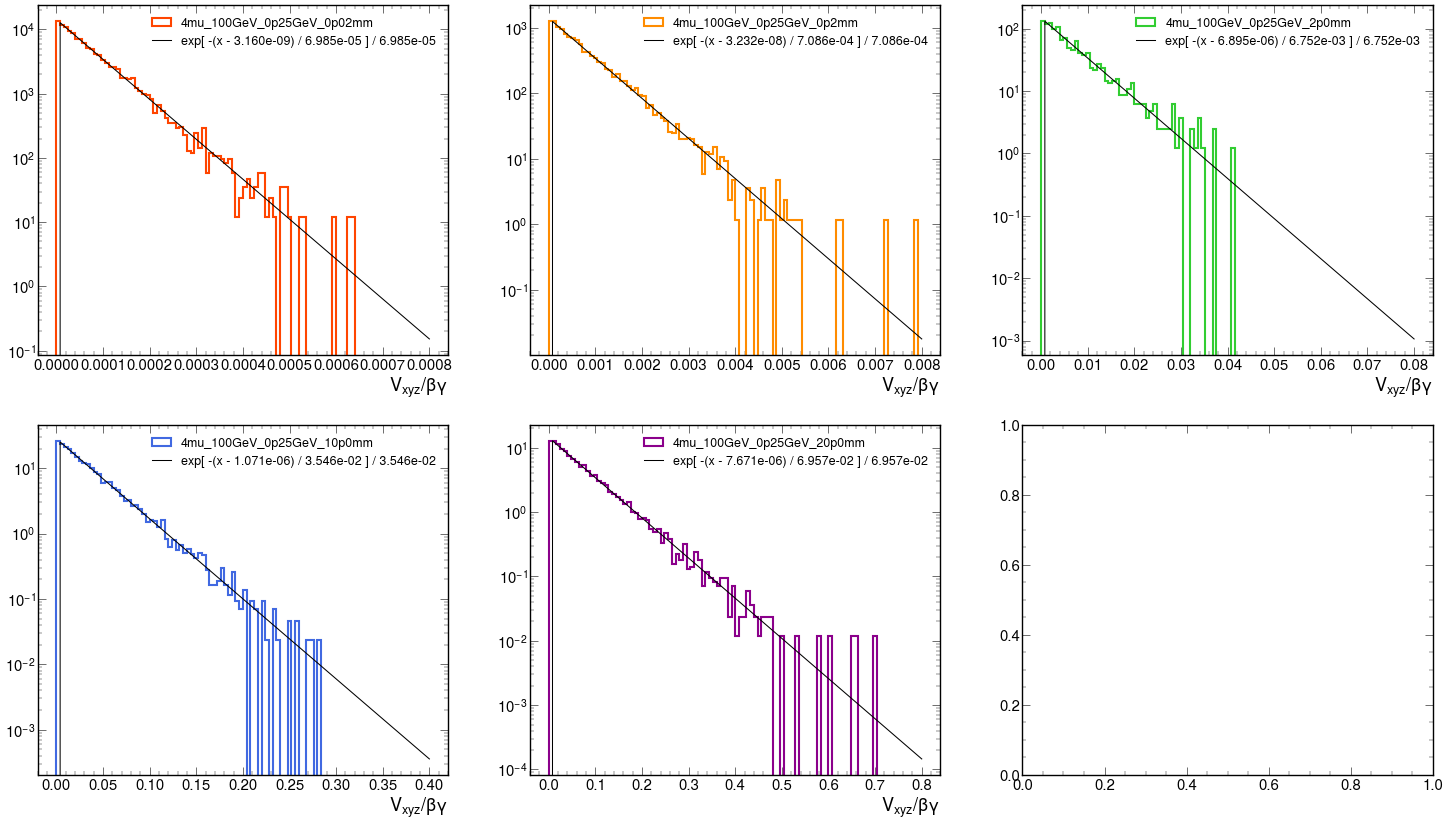

In [45]:
plt.style.use(hep.style.CMS)
fig, ax = plt.subplots(2, 3, figsize=(36, 20)) 

plotting(events_4mu, "4mu_100GeV_0p25GeV_0p02mm", 0.0008,0,0, "orangered")
plotting(events_4mu, "4mu_100GeV_0p25GeV_0p2mm", 0.008,0,1, "darkorange")
plotting(events_4mu, "4mu_100GeV_0p25GeV_2p0mm", 0.08,0,2, "limegreen")
plotting(events_4mu, "4mu_100GeV_0p25GeV_10p0mm", 0.4,1,0, "royalblue")
plotting(events_4mu, "4mu_100GeV_0p25GeV_20p0mm", 0.8,1,1, "darkmagenta")

DP mass : [[1.2, 1.21], [1.21, 1.2], [1.2, 1.21], ... [1.2, 1.2], [1.19, 1.2], [1.21, 1.2]]
DP mass : [[1.21, 1.19], [1.14, 1.21], [1.2, 1.2], ... [1.2, 1.18], [1.2, 1.21], [1.2, 1.2]]
DP mass : [[1.17, 1.21], [1.27, 1.2], [1.2, 1.2], ... [1.21, 1.2], [1.2, 1.21], [1.2, 1.2]]
DP mass : [[1.2, 1.18], [1.2, 1.16], [1.24, 1.2], ... [1.2, 1.2], [1.19, 1.19], [1.2, 1.2]]
DP mass : [[1.2, 1.2], [1.22, 1.2], [1.21, 1.25], ... [1.2, 1.21], [1.2, 1.18], [1.19, 1.24]]


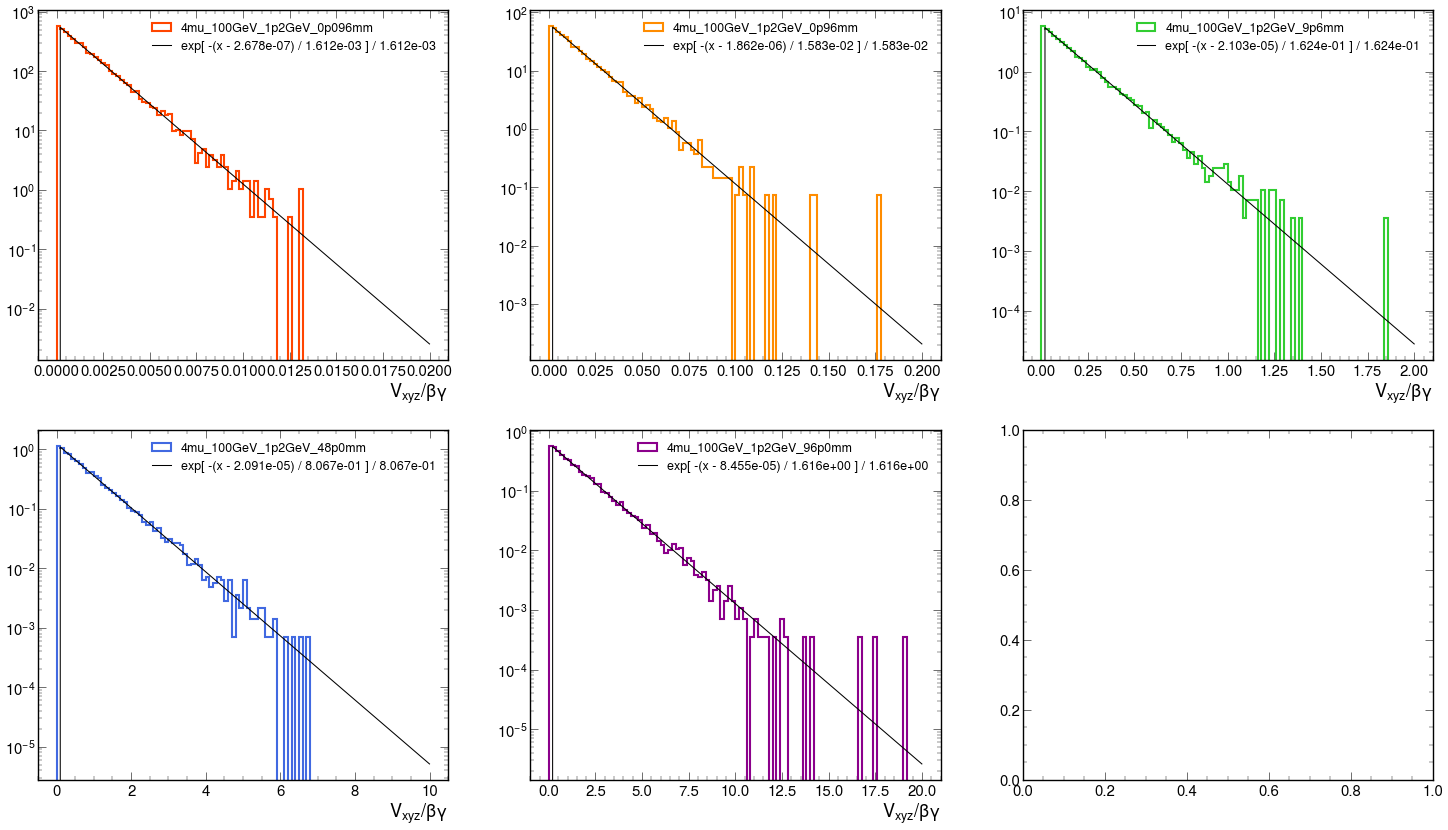

In [48]:
plt.style.use(hep.style.CMS)
fig, ax = plt.subplots(2, 3, figsize=(36, 20)) 

plotting(events_4mu, "4mu_100GeV_1p2GeV_0p096mm", 0.02,0,0, "orangered")
plotting(events_4mu, "4mu_100GeV_1p2GeV_0p96mm", 0.2,0,1, "darkorange")
plotting(events_4mu, "4mu_100GeV_1p2GeV_9p6mm", 2,0,2, "limegreen")
plotting(events_4mu, "4mu_100GeV_1p2GeV_48p0mm", 10,1,0, "royalblue")
plotting(events_4mu, "4mu_100GeV_1p2GeV_96p0mm", 20,1,1, "darkmagenta")

DP mass : [[5, 5.02], [5, 5], [5, 5], [5, 4.97], ... [5.02, 5], [5, 5.02], [5, 5], [5, 5]]
DP mass : [[5, 5], [4.97, 5], [5, 5], [5, 4.92, ... 5.02], [5, 4.97], [4.98, 4.98], [5.02, 5]]
DP mass : [[4.97, 5], [4.94, 5], [5, 5.03], [5, 5.09, ... 5], [5.02, 5], [5, 5], [4.98, 5.02]]
DP mass : [[5.02, 5], [4.98, 5], [5, 5], [5, 5], ... [5, 5.02], [5, 5], [4.98, 5], [5, 4.98]]
DP mass : [[5, 5.02], [5.03, 5], [5, 5], [5, 5.02], ... [5, 5], [4.98, 5], [5, 5], [5, 5]]


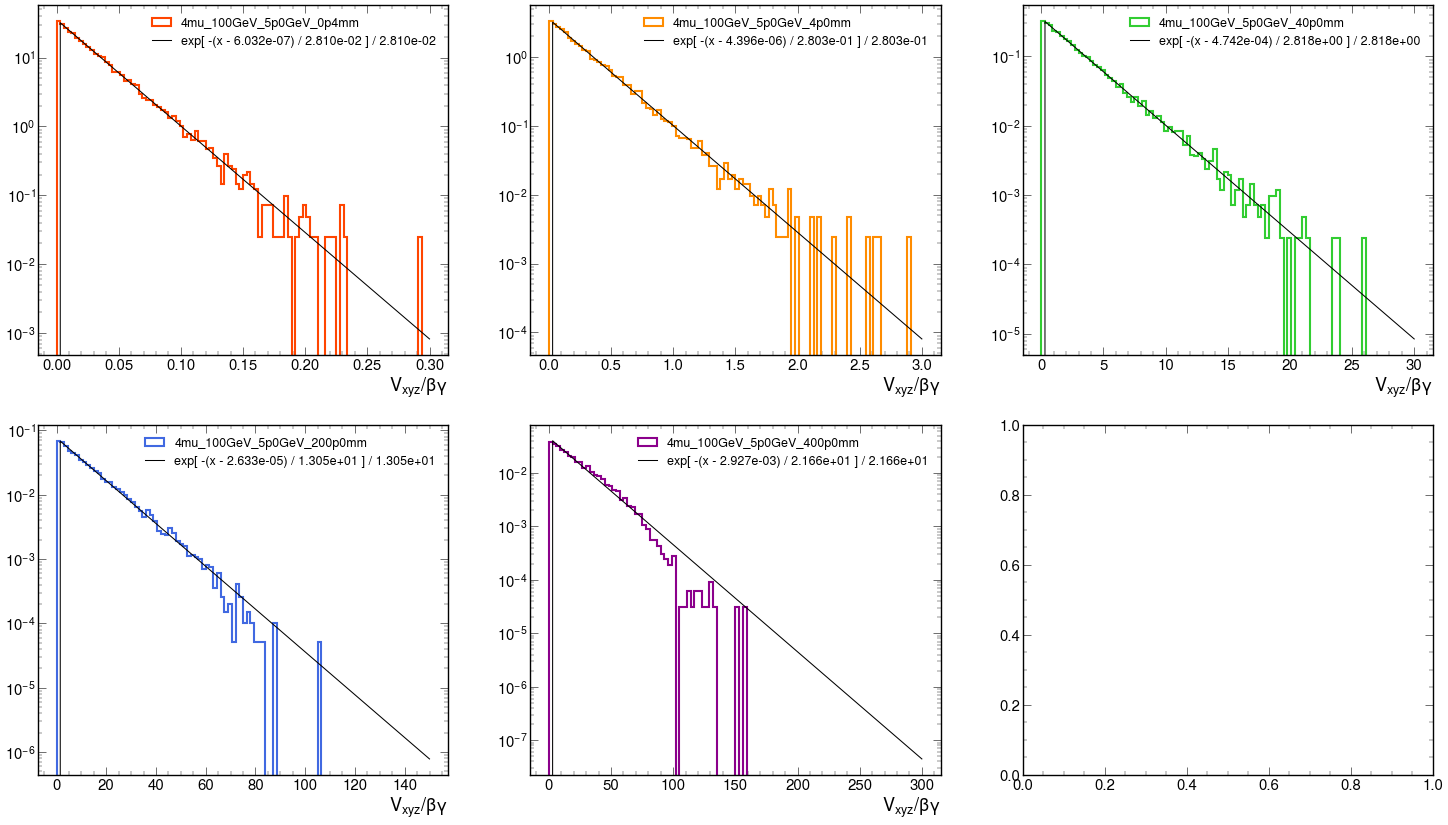

In [52]:
plt.style.use(hep.style.CMS)
fig, ax = plt.subplots(2, 3, figsize=(36, 20)) 

plotting(events_4mu, "4mu_100GeV_5p0GeV_0p4mm", 0.3,0,0, "orangered")
plotting(events_4mu, "4mu_100GeV_5p0GeV_4p0mm", 3,0,1, "darkorange")
plotting(events_4mu, "4mu_100GeV_5p0GeV_40p0mm", 30,0,2, "limegreen")
plotting(events_4mu, "4mu_100GeV_5p0GeV_200p0mm", 150,1,0, "royalblue")
plotting(events_4mu, "4mu_100GeV_5p0GeV_400p0mm", 300,1,1, "darkmagenta")

DP mass : [[0.316, 0.33], [0.251, 0.261], [0.263, ... 0.259], [0.241, 0.245], [0.261, 0.249]]
DP mass : [[0.252, 0.256], [0.253, 0.251], [0.258, ... 0.25], [0.241, 0.252], [0.247, 0.241]]
DP mass : [[0.254, 0.257], [0.248, 0.246], [0.252, ... 0.248], [0.267, 0.254], [0.255, 0.25]]
DP mass : [[0.273, 0.252], [0.26, 0.25], [0.239, ... 0.241], [0.239, 0.242], [0.279, 0.259]]
DP mass : [[0.252, 0.25], [0.249, 0.242], [0.251, ... 0.251], [0.25, 0.251], [0.25, 0.251]]


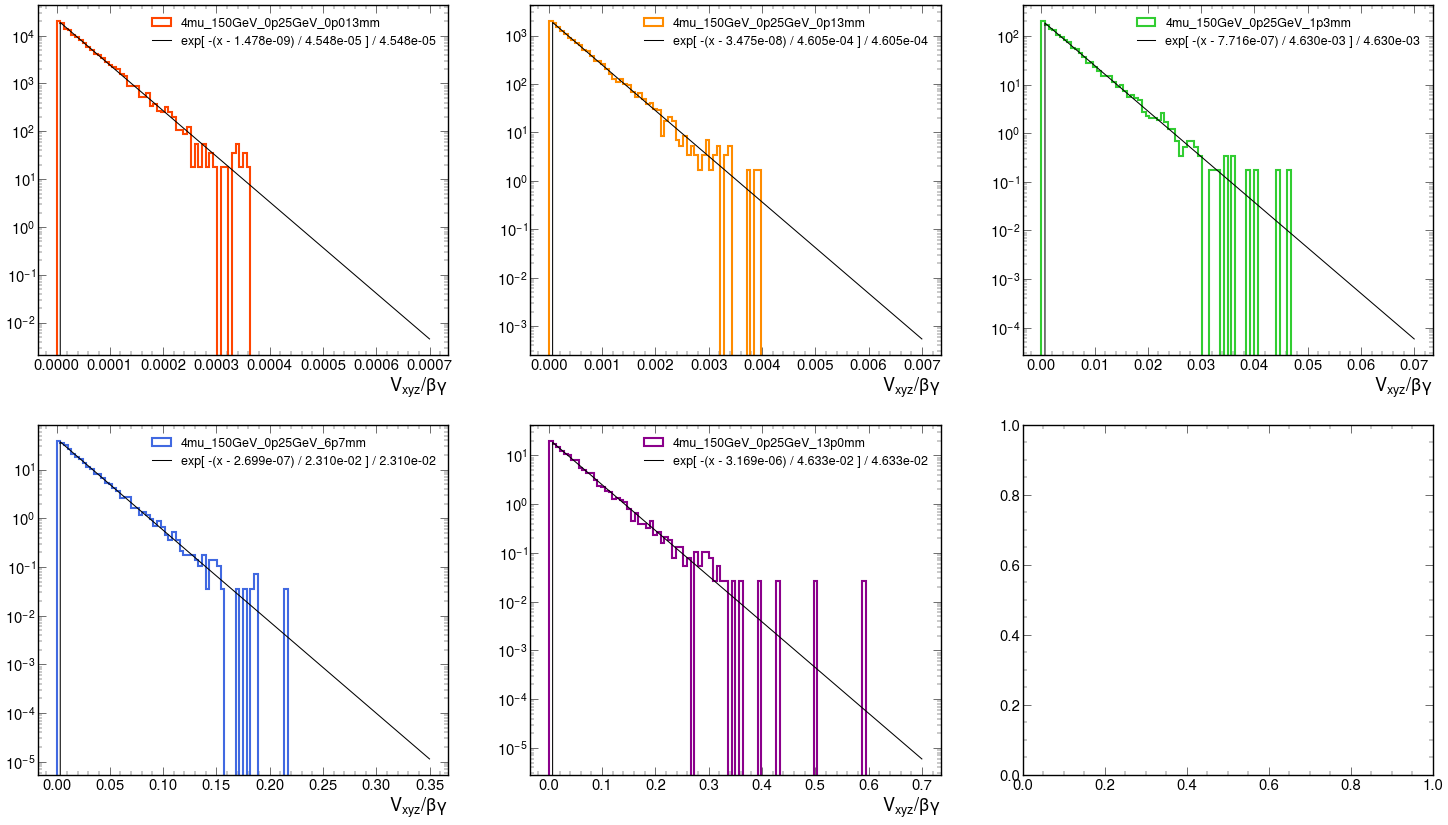

In [53]:
plt.style.use(hep.style.CMS)
fig, ax = plt.subplots(2, 3, figsize=(36, 20)) 

plotting(events_4mu, "4mu_150GeV_0p25GeV_0p013mm", 0.0007,0,0, "orangered")
plotting(events_4mu, "4mu_150GeV_0p25GeV_0p13mm", 0.007,0,1, "darkorange")
plotting(events_4mu, "4mu_150GeV_0p25GeV_1p3mm", 0.07,0,2, "limegreen")
plotting(events_4mu, "4mu_150GeV_0p25GeV_6p7mm", 0.35,1,0, "royalblue")
plotting(events_4mu, "4mu_150GeV_0p25GeV_13p0mm", 0.7,1,1, "darkmagenta")

DP mass : [[1.17, 1.21], [1.11, 1.2], [1.2, 1.2], ... [1.2, 1.2], [1.2, 1.2], [1.2, 1.17]]
DP mass : [[1.2, 1.2], [1.21, 1.18], [1.2, 1.2], ... [1.2, 1.29], [1.21, 1.2], [1.2, 1.2]]
DP mass : [[1.2, 1.2], [1.21, 1.2], [1.2, 1.2], ... [1.21, 1.25], [1.2, 1.2], [1.21, 1.2]]
DP mass : [[1.19, 1.2], [1.22, 1.19], [1.16, 1.2], ... [1.2, 1.2], [1.2, 1.2], [1.2, 1.2]]
DP mass : [[1.2, 1.2], [1.22, 1.2], [1.19, 1.2], ... [1.19, 1.21], [1.2, 1.16], [1.09, 1.2]]


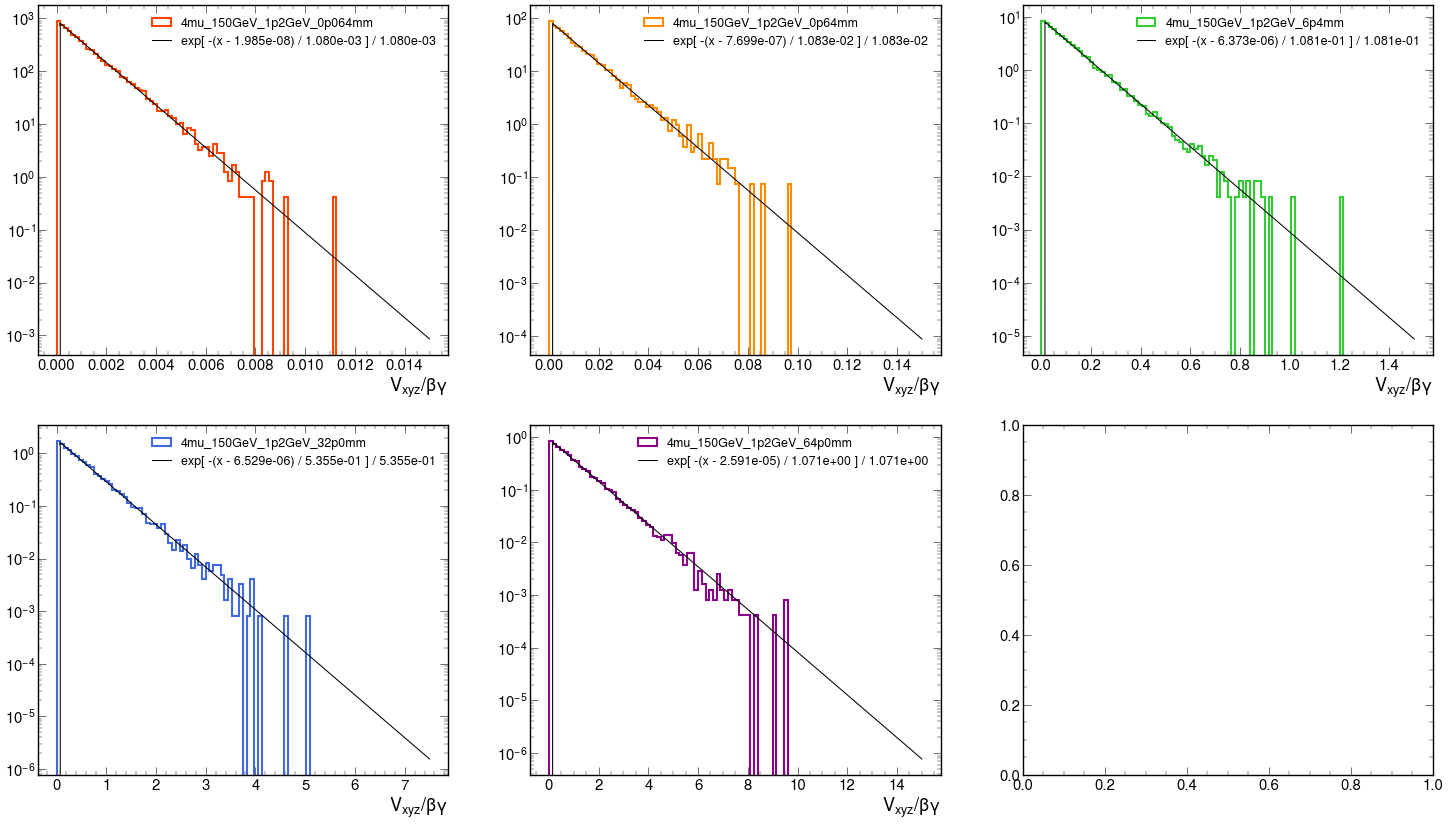

In [58]:
plt.style.use(hep.style.CMS)
fig, ax = plt.subplots(2, 3, figsize=(36, 20)) 

plotting(events_4mu, "4mu_150GeV_1p2GeV_0p064mm", 0.015,0,0, "orangered")
plotting(events_4mu, "4mu_150GeV_1p2GeV_0p64mm", 0.15,0,1, "darkorange")
plotting(events_4mu, "4mu_150GeV_1p2GeV_6p4mm", 1.5,0,2,"limegreen")
plotting(events_4mu, "4mu_150GeV_1p2GeV_32p0mm", 7.5,1,0, "royalblue")
plotting(events_4mu, "4mu_150GeV_1p2GeV_64p0mm", 15,1,1, "darkmagenta")

DP mass : [[5, 5], [5.03, 5], [4.89, 5.02], [5, ... 5.02], [5, 5.02], [5, 5.03], [5.02, 5]]
DP mass : [[5, 5.05], [5, 5], [5, 5], [5, 5], ... [4.98, 5], [5.02, 5], [5, 5], [5.02, 4.98]]
DP mass : [[5.02, 5], [5, 5], [5, 5], [4.98, 5], ... [5, 5.02], [5, 4.97], [4.97, 5], [5, 5]]
DP mass : [[5, 4.98], [5, 5.02], [5, 5], [5.09, 5], ... 5, 5], [5, 5], [5.05, 4.89], [5.02, 5]]
DP mass : [[5, 4.98], [5, 5], [5.02, 5], [4.98, 5], ... 5.02, 5], [5.06, 5], [5, 5.03], [5, 5]]


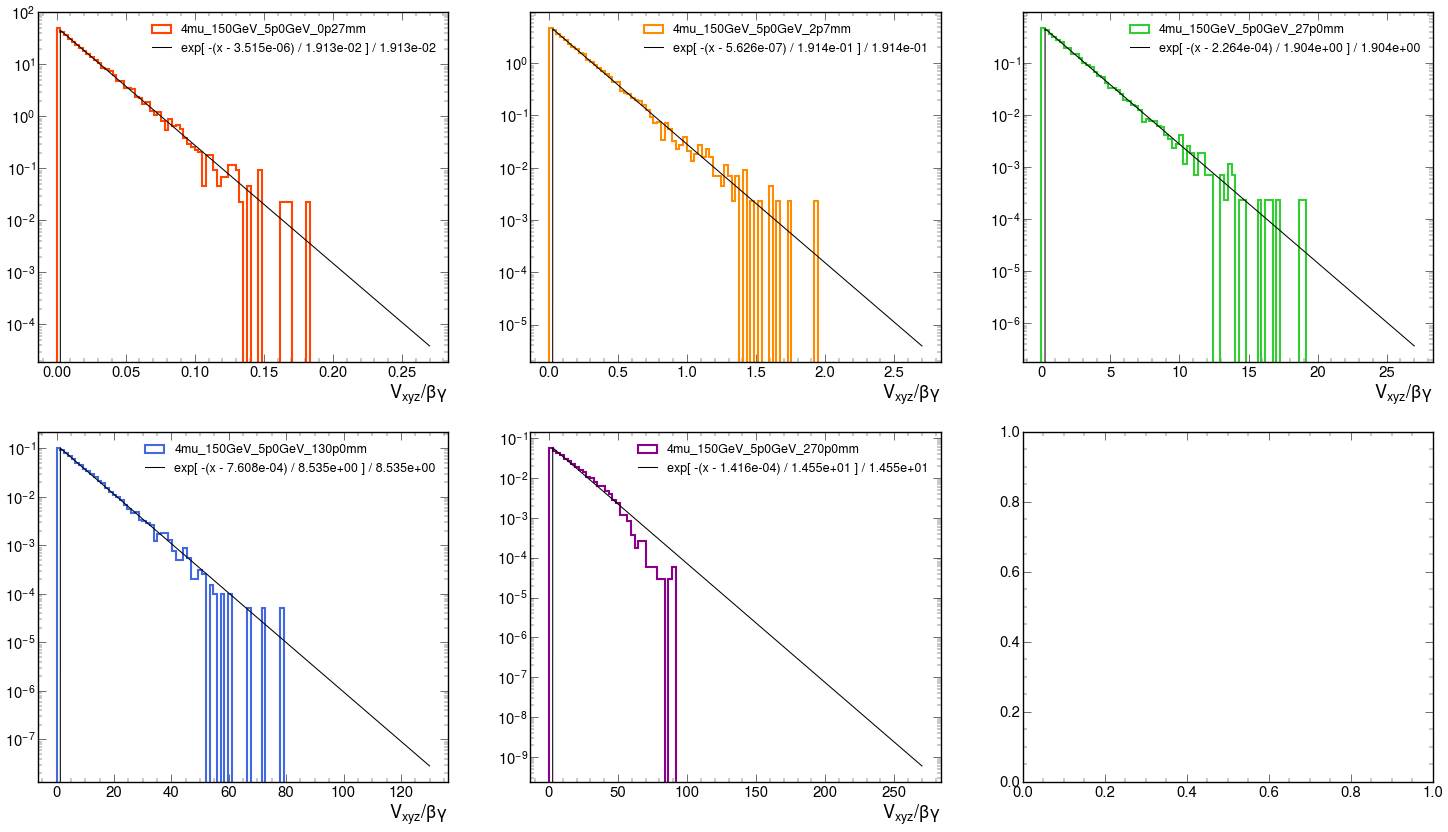

In [59]:
plt.style.use(hep.style.CMS)
fig, ax = plt.subplots(2, 3, figsize=(36, 20)) 

plotting(events_4mu, "4mu_150GeV_5p0GeV_0p27mm", 0.27,0,0, "orangered")
plotting(events_4mu, "4mu_150GeV_5p0GeV_2p7mm", 2.7,0,1, "darkorange")
plotting(events_4mu, "4mu_150GeV_5p0GeV_27p0mm", 27,0,2,"limegreen")
plotting(events_4mu, "4mu_150GeV_5p0GeV_130p0mm", 130,1,0, "royalblue")
plotting(events_4mu, "4mu_150GeV_5p0GeV_270p0mm", 270,1,1, "darkmagenta")

DP mass : [[0.261, 0.248], [0.324, 0.245], [0.26, ... 0.249], [0.254, 0.251], [0.241, 0.254]]
DP mass : [[0.252, 0.254], [0.261, 0.244], [0.25, ... 0.25], [0.254, 0.253], [0.259, 0.328]]
DP mass : [[0.283, 0.248], [0.378, 0.248], [0.248, ... 0.251], [0.25, 0.26], [0.263, 0.259]]
DP mass : [[0.252, 0.245], [0.228, 0.249], [0.249, ... 0.313], [0.253, 0.249], [0.253, 0.257]]
DP mass : [[0.251, 0.308], [0.277, 0.255], [0.272, ... 0.246], [0.249, 0.258], [0.257, 0.245]]


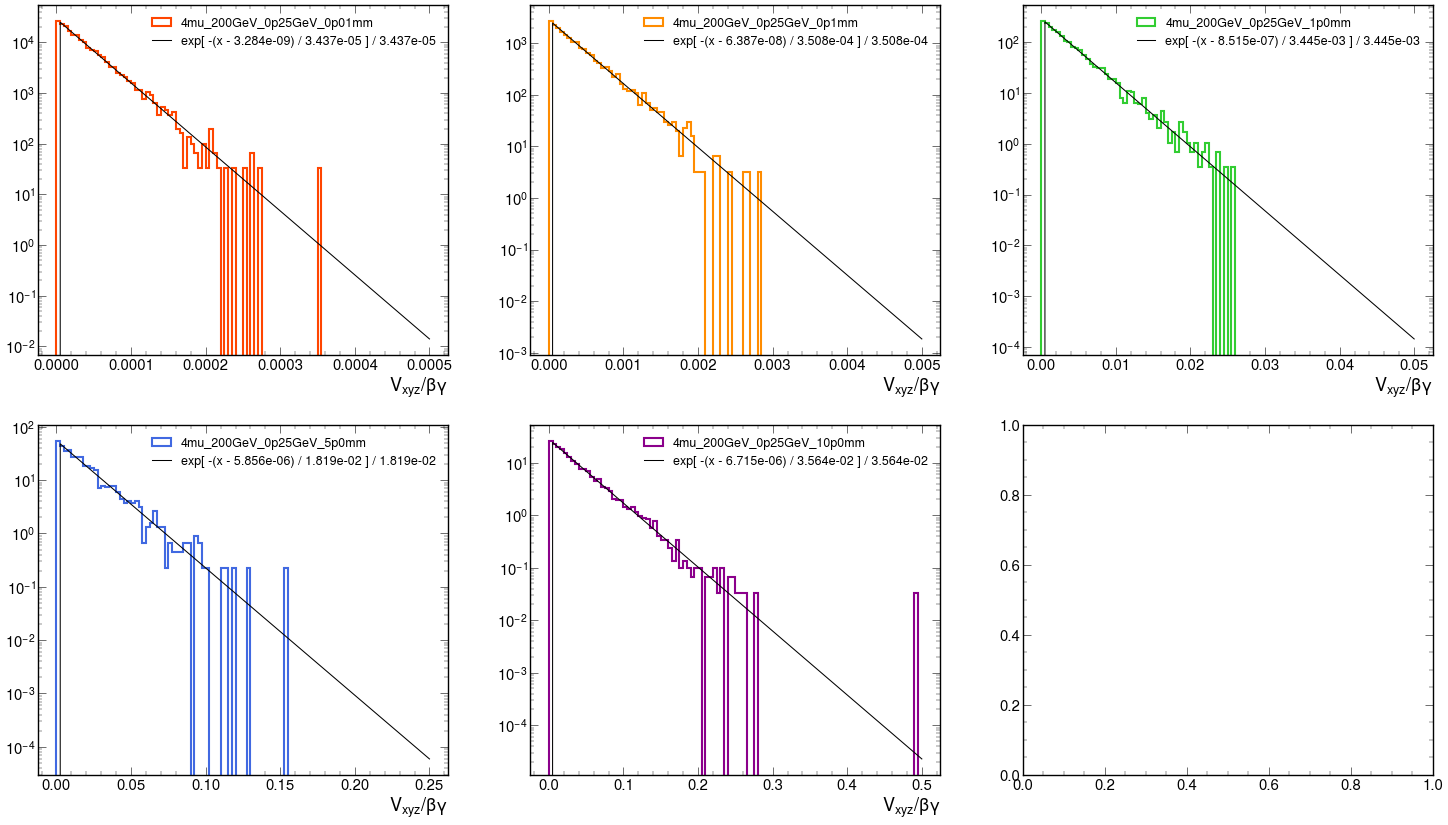

In [62]:
plt.style.use(hep.style.CMS)
fig, ax = plt.subplots(2, 3, figsize=(36, 20)) 

plotting(events_4mu, "4mu_200GeV_0p25GeV_0p01mm", 0.0005,0,0, "orangered")
plotting(events_4mu, "4mu_200GeV_0p25GeV_0p1mm", 0.005,0,1, "darkorange")
plotting(events_4mu, "4mu_200GeV_0p25GeV_1p0mm", 0.05,0,2,"limegreen")
plotting(events_4mu, "4mu_200GeV_0p25GeV_5p0mm", 0.25,1,0, "royalblue")
plotting(events_4mu, "4mu_200GeV_0p25GeV_10p0mm", 0.5,1,1, "darkmagenta")

DP mass : [[1.2, 1.19], [1.18, 1.23], [1.15, 1.18], ... [1.13, 1.29], [1.2, 1.21], [1.2, 1.21]]
DP mass : [[1.19, 1.2], [1.22, 1.2], [1.21, 1.2], ... [1.19, 1.2], [1.12, 1.21], [1.2, 1.2]]
DP mass : [[1.21, 1.15], [1.22, 1.2], [1.2, 1.21], ... [1.2, 1.2], [1.2, 1.25], [1.2, 1.2]]
DP mass : [[1.2, 1.25], [1.18, 1.2], [1.21, 1.2], ... [1.2, 1.2], [1.2, 1.2], [1.19, 1.21]]
DP mass : [[1.2, 1.23], [1.21, 1.22], [1.2, 1.2], ... [1.19, 1.2], [1.23, 1.25], [1.21, 1.2]]


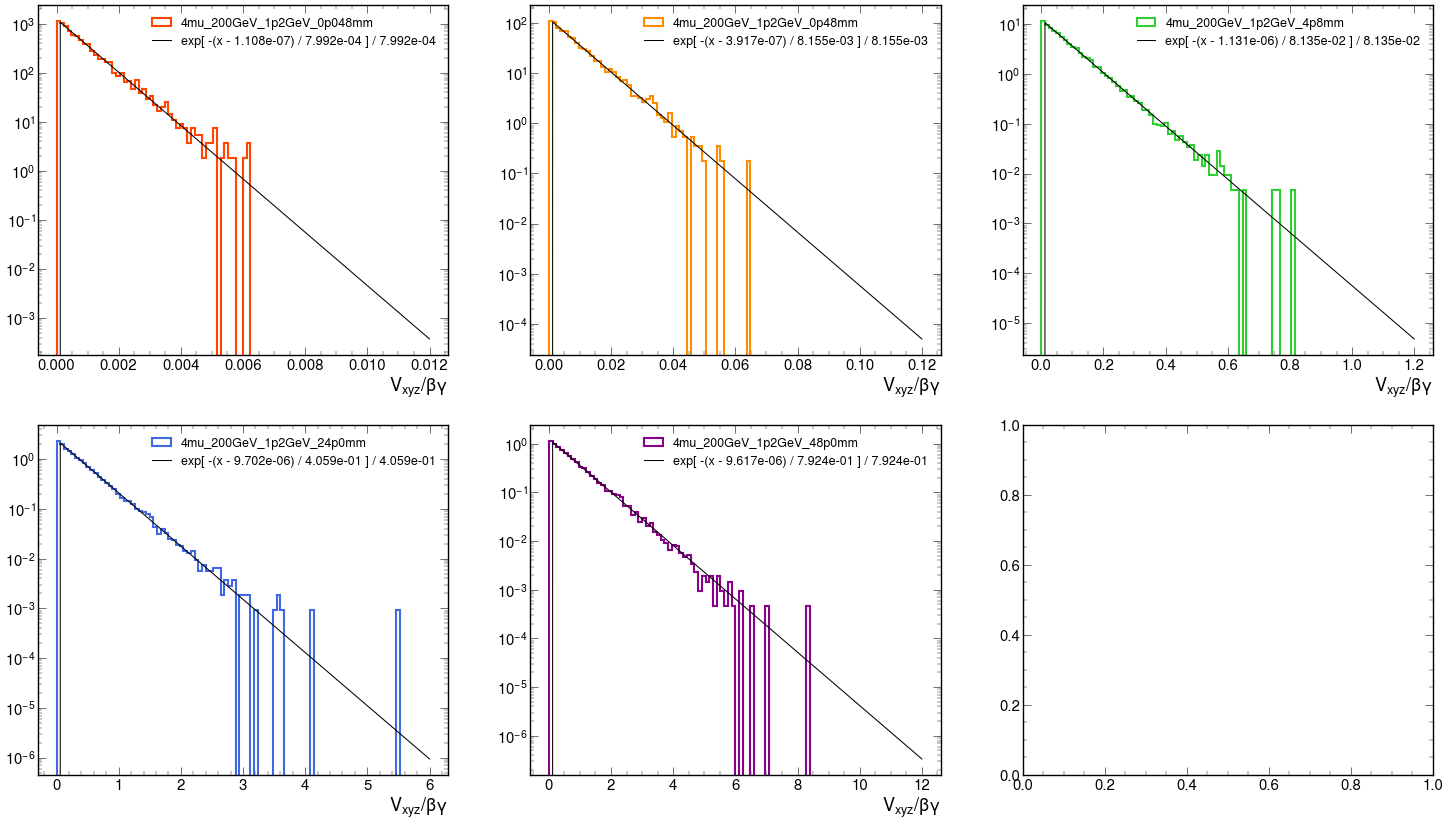

In [65]:
plt.style.use(hep.style.CMS)
fig, ax = plt.subplots(2, 3, figsize=(36, 20)) 

plotting(events_4mu, "4mu_200GeV_1p2GeV_0p048mm", 0.012,0,0, "orangered")
plotting(events_4mu, "4mu_200GeV_1p2GeV_0p48mm", 0.12,0,1, "darkorange")
plotting(events_4mu, "4mu_200GeV_1p2GeV_4p8mm", 1.2,0,2,"limegreen")
plotting(events_4mu, "4mu_200GeV_1p2GeV_24p0mm", 6,1,0, "royalblue")
plotting(events_4mu, "4mu_200GeV_1p2GeV_48p0mm", 12,1,1, "darkmagenta")

DP mass : [[5, 5], [5, 5], [5, 5], [5, 5.02], ... [5.02, 5], [4.95, 5], [5, 4.94], [5, 5]]
DP mass : [[5, 5], [5, 5.03], [5, 4.98], [4.98, 4.98], ... 4.95, 5], [5, 4.95], [5, 5], [5, 5]]
DP mass : [[5, 5], [5, 5.02], [5, 5], [5, 5.02], [5, ... 5], [4.98, 5], [5, 5], [5, 5], [5, 5]]
DP mass : [[5.02, 4.98], [5, 5], [5, 5], [5.02, 5], ... 4.97, 4.98], [5, 5], [5.09, 5], [5, 5]]
DP mass : [[5, 4.98], [5, 5], [5, 5], [4.98, 5], [5, ... 4.98], [5, 5], [5, 5], [5, 5], [5, 5]]


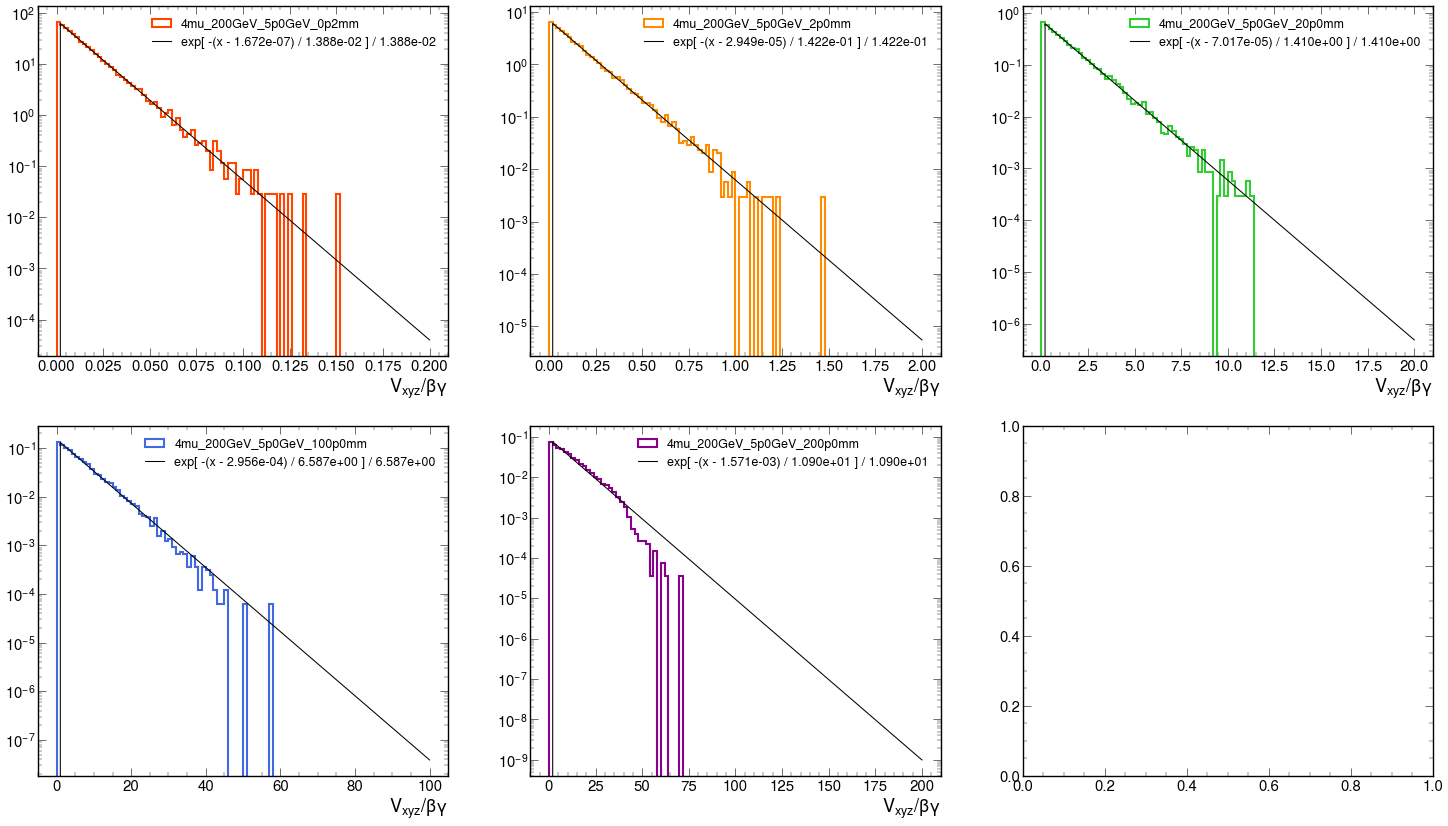

In [66]:
plt.style.use(hep.style.CMS)
fig, ax = plt.subplots(2, 3, figsize=(36, 20)) 

plotting(events_4mu, "4mu_200GeV_5p0GeV_0p2mm", 0.2,0,0, "orangered")
plotting(events_4mu, "4mu_200GeV_5p0GeV_2p0mm", 2,0,1, "darkorange")
plotting(events_4mu, "4mu_200GeV_5p0GeV_20p0mm", 20,0,2,"limegreen")
plotting(events_4mu, "4mu_200GeV_5p0GeV_100p0mm", 100,1,0, "royalblue")
plotting(events_4mu, "4mu_200GeV_5p0GeV_200p0mm", 200,1,1, "darkmagenta")

DP mass : [[0.262, 0.254], [0.26, 0.277], [0.254, ... 0.319], [0.262, 0.253], [0.241, 0.252]]
DP mass : [[0.251, 0.247], [0.265, 0.243], [0.252, ... 0.236], [0.245, 0.243], [0.315, 0.3]]
DP mass : [[0.25, 0.259], [0.282, 0.271], [0.249, ... 0.261], [0.254, 0.246], [0.259, 0.276]]
DP mass : [[0.252, 0.255], [0.324, 0.252], [0.303, ... 0.247], [0.337, 0.253], [0.249, 0.26]]
DP mass : [[0.258, 0.299], [0.263, 0.268], [0.308, ... 0.262], [0.248, 0.249], [0.262, 0.255]]


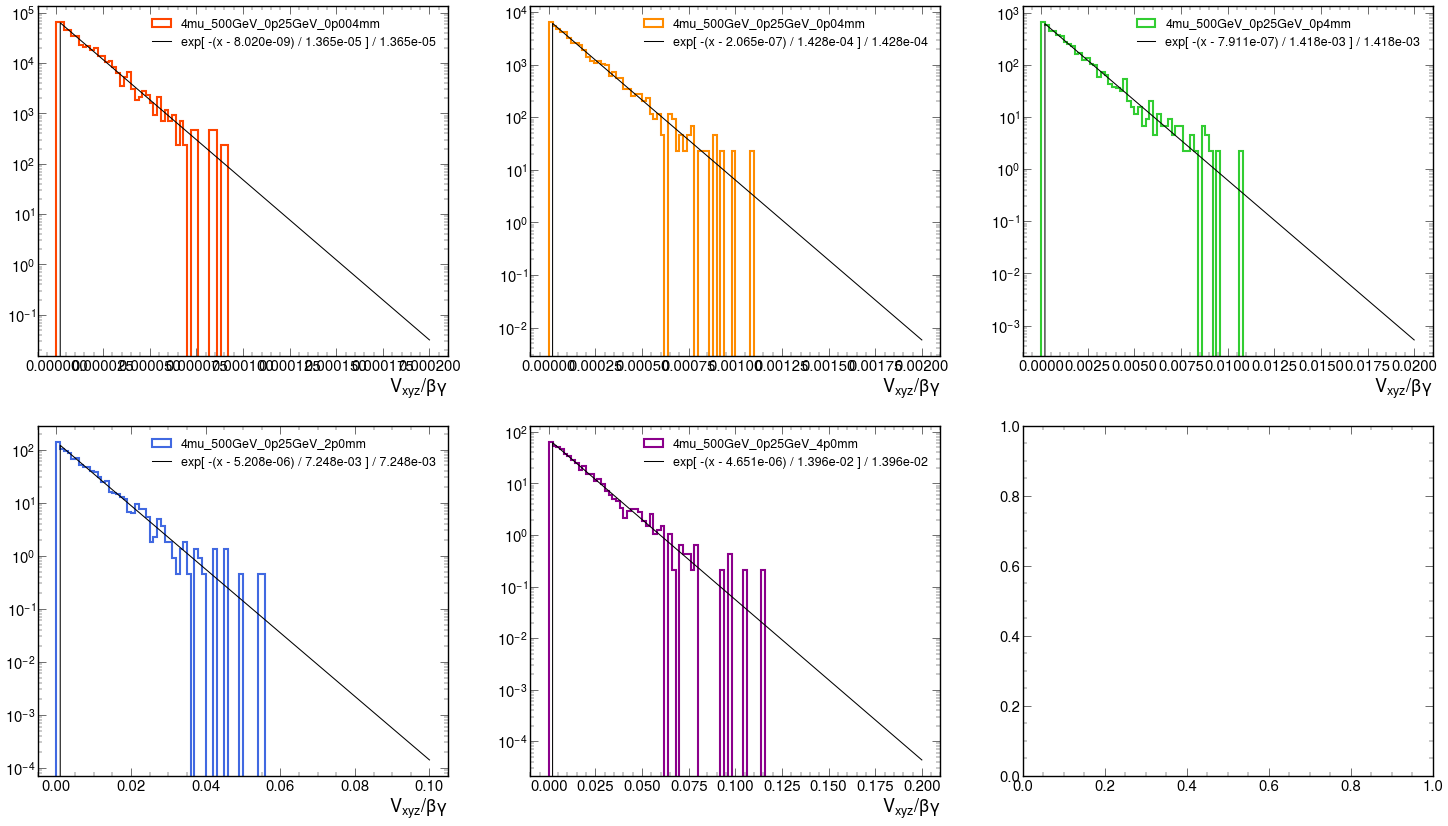

In [69]:
plt.style.use(hep.style.CMS)
fig, ax = plt.subplots(2, 3, figsize=(36, 20)) 

plotting(events_4mu, "4mu_500GeV_0p25GeV_0p004mm", 0.0002,0,0, "orangered")
plotting(events_4mu, "4mu_500GeV_0p25GeV_0p04mm", 0.002,0,1, "darkorange")
plotting(events_4mu, "4mu_500GeV_0p25GeV_0p4mm", 0.02,0,2,"limegreen")
plotting(events_4mu, "4mu_500GeV_0p25GeV_2p0mm", 0.1,1,0, "royalblue")
plotting(events_4mu, "4mu_500GeV_0p25GeV_4p0mm", 0.2,1,1, "darkmagenta")

DP mass : [[1.15, 1.2], [1.2, 1.2], [1.2, 1.2], ... [1.2, 1.2], [1.16, 1.2], [1.2, 1.2]]
DP mass : [[1.2, 1.2], [1.2, 1.2], [1.2, 1.21], ... [1.2, 1.21], [1.21, 1.2], [1.2, 1.2]]
DP mass : [[1.19, 1.2], [1.2, 1.2], [1.2, 1.2], ... [1.2, 1.2], [1.2, 1.2], [1.2, 1.2]]
DP mass : [[1.19, 1.16], [1.23, 1.21], [1.2, 1.22], ... [1.17, 1.2], [1.21, 1.21], [1.2, 1.2]]
DP mass : [[1.21, 1.2], [1.2, 1.21], [1.2, 1.2], ... [1.2, 1.2], [1.2, 1.2], [1.18, 1.1]]


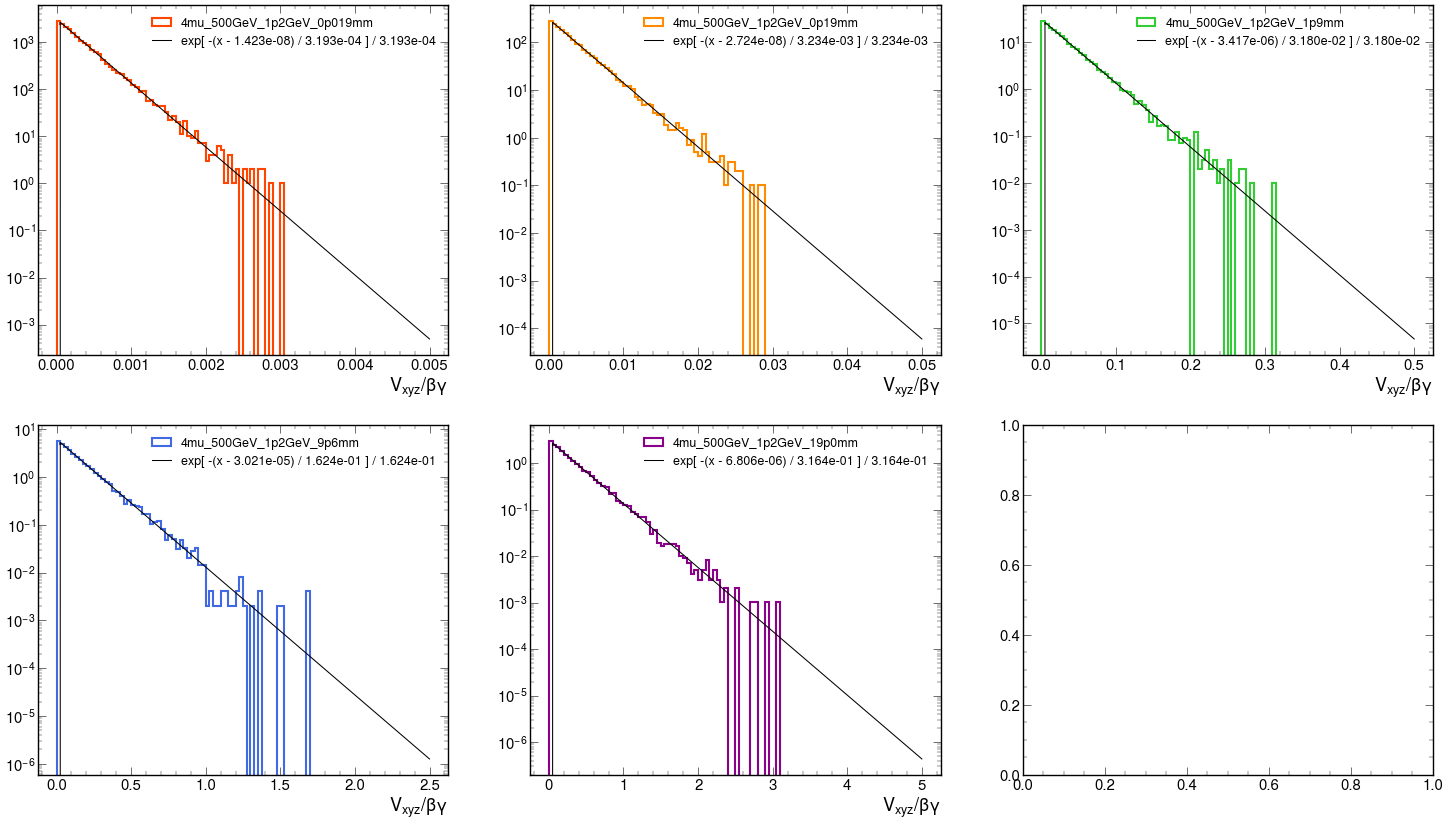

In [71]:
plt.style.use(hep.style.CMS)
fig, ax = plt.subplots(2, 3, figsize=(36, 20)) 

plotting(events_4mu, "4mu_500GeV_1p2GeV_0p019mm", 0.005,0,0, "orangered")
plotting(events_4mu, "4mu_500GeV_1p2GeV_0p19mm", 0.05,0,1, "darkorange")
plotting(events_4mu, "4mu_500GeV_1p2GeV_1p9mm", 0.5,0,2,"limegreen")
plotting(events_4mu, "4mu_500GeV_1p2GeV_9p6mm", 2.5,1,0, "royalblue")
plotting(events_4mu, "4mu_500GeV_1p2GeV_19p0mm", 5,1,1, "darkmagenta")

DP mass : [[4.98, 5], [4.98, 5], [5.02, 5.02], [5, 4.91, ... 4.98], [5.12, 5], [5, 5], [5, 5]]
DP mass : [[4.98, 4.98], [5, 5.06], [5.03, 5], [4.95, 5, ... 5], [4.97, 5], [5, 5], [5.06, 5]]
DP mass : [[5, 5], [5.05, 5.02], [5.02, 5], [4.94, 4.98, ... 4.98], [5, 5], [5.02, 5], [5, 5]]
DP mass : [[5, 5], [5, 5], [5, 5], [5, 5], [5, 5, ... 5], [5, 5], [5, 5], [4.98, 5], [5, 5.02]]
DP mass : [[5, 5], [4.98, 5.02], [5.02, 5], [4.98, 5, ... 5], [5, 5.02], [5, 5.03], [5, 5]]


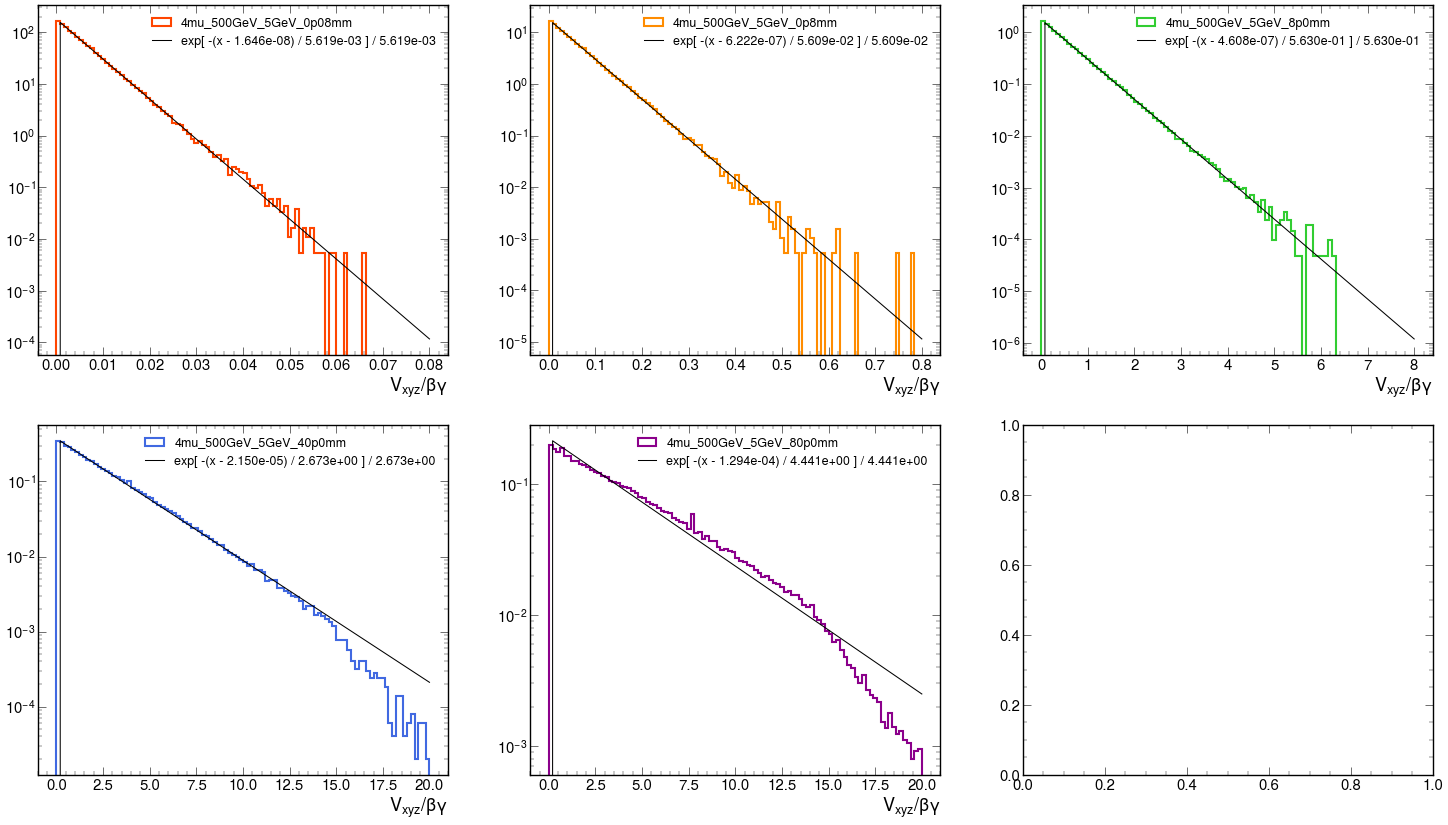

In [11]:
plt.style.use(hep.style.CMS)
fig, ax = plt.subplots(2, 3, figsize=(36, 20)) 

plotting(events_4mu, "4mu_500GeV_5GeV_0p08mm", 0.08,0,0, "orangered")
plotting(events_4mu, "4mu_500GeV_5GeV_0p8mm", 0.8,0,1, "darkorange")
plotting(events_4mu, "4mu_500GeV_5GeV_8p0mm", 8,0,2, "limegreen")
plotting(events_4mu, "4mu_500GeV_5GeV_40p0mm", 20,1,0, "royalblue")
plotting(events_4mu, "4mu_500GeV_5GeV_80p0mm", 20,1,1, "darkmagenta")

DP mass : [[0.274, 0.264], [0.288, 0.284], [0.34, ... 0.3], [0.322, 0.329], [0.317, 0.254]]
DP mass : [[0.355, 0.34], [0.253, 0.257], [0.279, ... 0.259], [0.256, 0.338], [0.276, 0.282]]
DP mass : [[0.293, 0.293], [0.263, 0.323], [0.307, ... 0.297], [0.324, 0.329], [0.357, 0.316]]
DP mass : [[0.266, 0.25], [0.298, 0.256], [0.381, ... 0.283], [0.263, 0.258], [0.259, 0.265]]
DP mass : [[0.263, 0.273], [0.313, 0.326], [0.291, ... 0.368], [0.398, 0.336], [0.309, 0.336]]


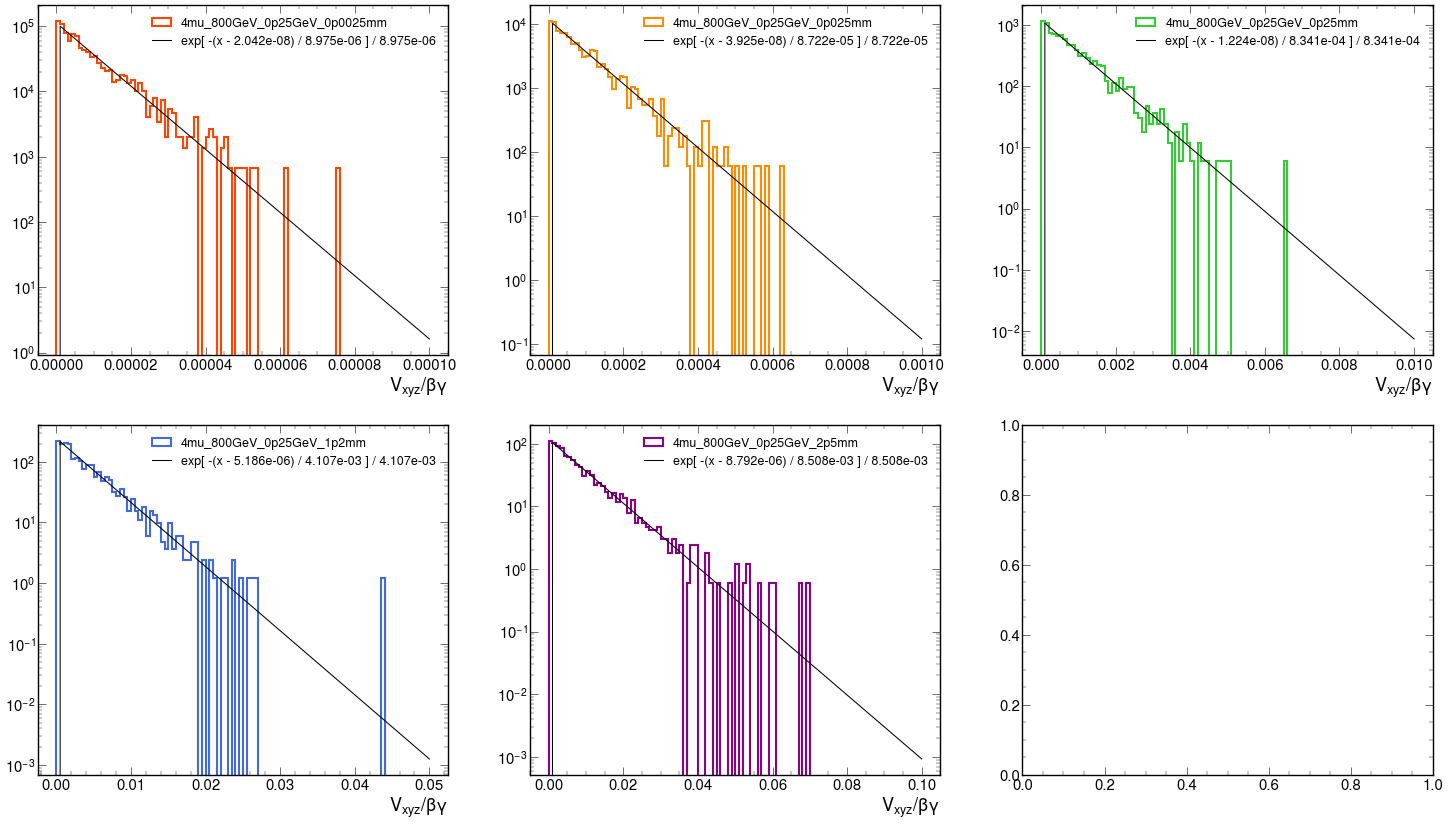

In [75]:
plt.style.use(hep.style.CMS)
fig, ax = plt.subplots(2, 3, figsize=(36, 20)) 

plotting(events_4mu, "4mu_800GeV_0p25GeV_0p0025mm", 0.0001,0,0, "orangered")
plotting(events_4mu, "4mu_800GeV_0p25GeV_0p025mm", 0.001,0,1, "darkorange")
plotting(events_4mu, "4mu_800GeV_0p25GeV_0p25mm", 0.01,0,2, "limegreen")
plotting(events_4mu, "4mu_800GeV_0p25GeV_1p2mm", 0.05,1,0, "royalblue")
plotting(events_4mu, "4mu_800GeV_0p25GeV_2p5mm", 0.1,1,1, "darkmagenta")

DP mass : [[1.32, 1.22], [1.2, 1.2], [1.27, 1.2], ... [1.2, 1.2], [1.2, 1.15], [1.2, 1.21]]
DP mass : [[1.2, 1.21], [1.19, 1.2], [1.21, 1.19], ... [1.2, 1.2], [1.2, 1.2], [1.2, 1.21]]
DP mass : [[1.19, 1.2], [1.2, 1.2], [1.2, 1.2], ... [1.21, 1.21], [1.21, 1.2], [1.2, 1.2]]
DP mass : [[1.25, 1.21], [1.2, 1.21], [1.2, 1.2], ... [1.22, 1.2], [1.2, 1.2], [1.19, 1.21]]
DP mass : [[1.21, 1.2], [1.2, 1.2], [1.2, 1.2], ... [1.15, 1.2], [1.2, 1.2], [1.2, 1.2]]


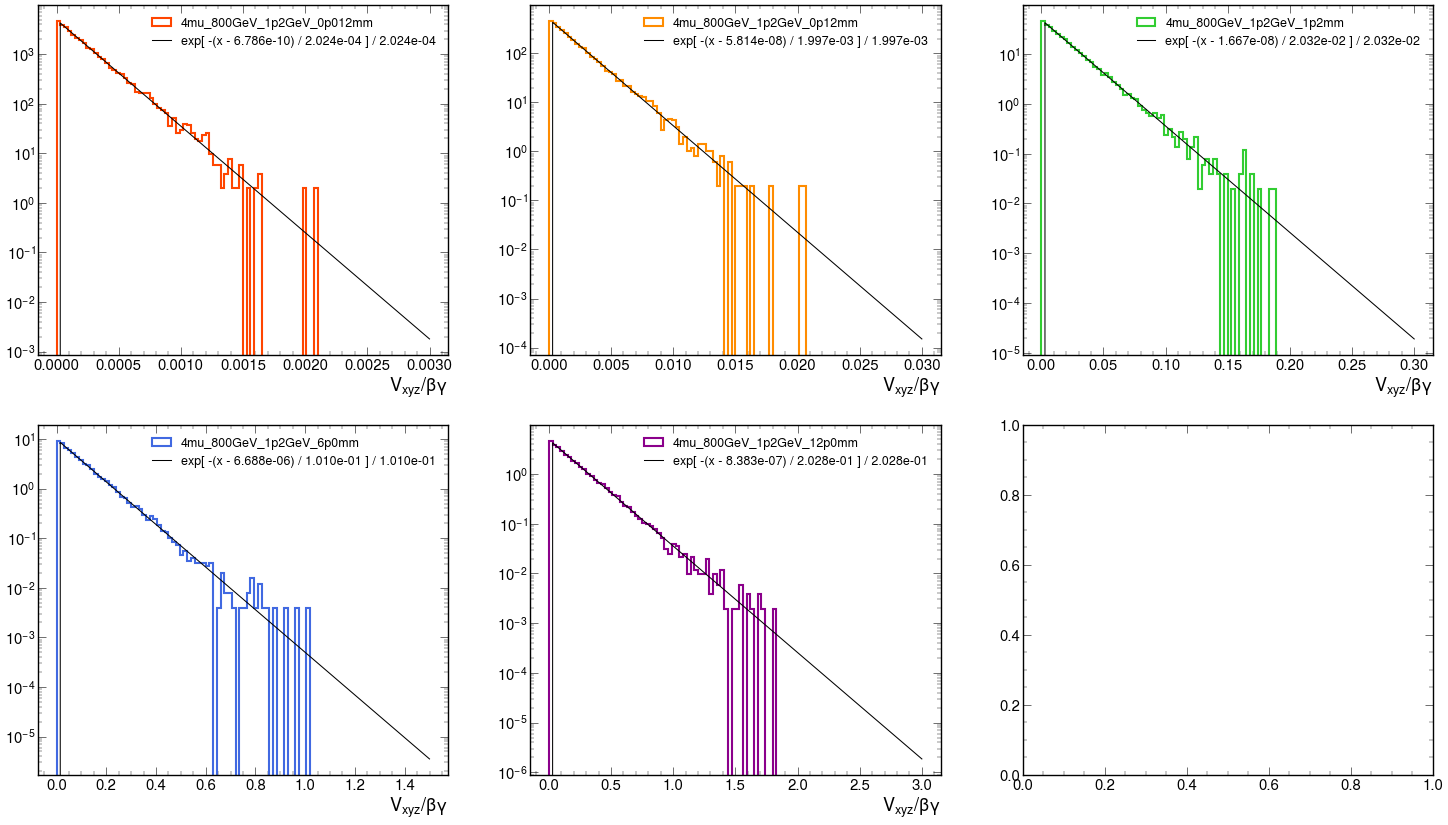

In [78]:
plt.style.use(hep.style.CMS)
fig, ax = plt.subplots(2, 3, figsize=(36, 20)) 

plotting(events_4mu, "4mu_800GeV_1p2GeV_0p012mm", 0.003,0,0, "orangered")
plotting(events_4mu, "4mu_800GeV_1p2GeV_0p12mm", 0.03,0,1, "darkorange")
plotting(events_4mu, "4mu_800GeV_1p2GeV_1p2mm", 0.3,0,2, "limegreen")
plotting(events_4mu, "4mu_800GeV_1p2GeV_6p0mm", 1.5,1,0, "royalblue")
plotting(events_4mu, "4mu_800GeV_1p2GeV_12p0mm", 3,1,1, "darkmagenta")

DP mass : [[5, 5], [5, 5], [5, 5], [5.02, 4.97, ... 4.98], [4.97, 4.98], [5, 5], [5.03, 5]]
DP mass : [[5, 5], [5.02, 5], [5, 4.92], [5.11, 5, ... 4.98], [5, 5], [4.98, 5], [5, 4.98]]
DP mass : [[5.02, 5], [5, 5], [5.02, 5], [5.02, 5], ... 5, 4.98], [5, 4.97], [5, 5], [5.02, 5]]
DP mass : [[5, 5], [5, 5], [5, 5], [5, 4.98], [5, ... 5], [5.02, 5], [5, 5], [5, 4.92], [5, 5]]
DP mass : [[5, 5], [5, 5], [5.03, 5.02], [5, 5], [5, ... 5], [5, 5.02], [5, 5], [5, 5], [5, 5]]


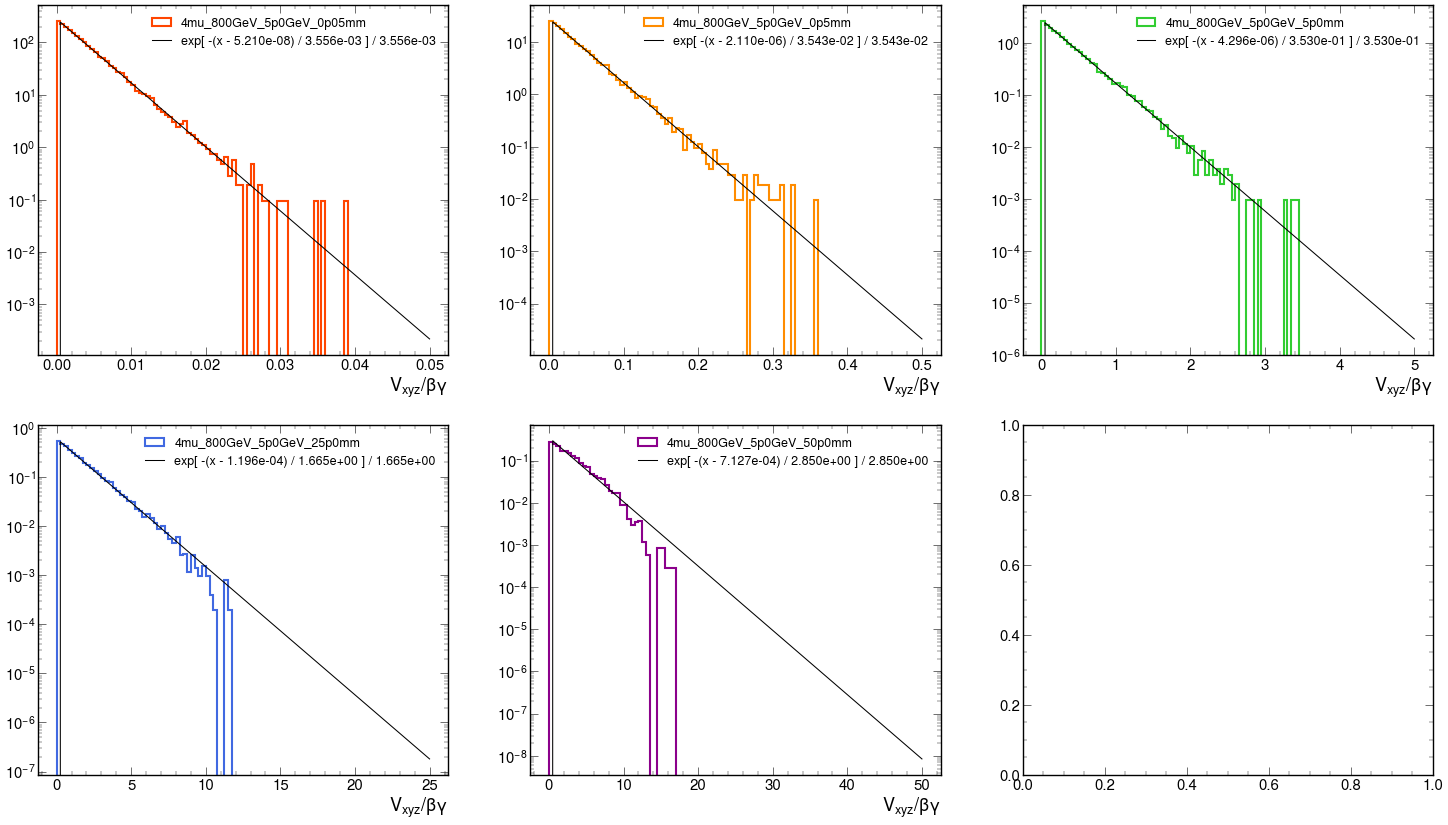

In [79]:
plt.style.use(hep.style.CMS)
fig, ax = plt.subplots(2, 3, figsize=(36, 20)) 

plotting(events_4mu, "4mu_800GeV_5p0GeV_0p05mm", 0.05,0,0, "orangered")
plotting(events_4mu, "4mu_800GeV_5p0GeV_0p5mm", 0.5,0,1, "darkorange")
plotting(events_4mu, "4mu_800GeV_5p0GeV_5p0mm", 5,0,2, "limegreen")
plotting(events_4mu, "4mu_800GeV_5p0GeV_25p0mm", 25,1,0, "royalblue")
plotting(events_4mu, "4mu_800GeV_5p0GeV_50p0mm", 50,1,1, "darkmagenta")

AttributeError: no field named 'GenPart'

(https://github.com/scikit-hep/awkward-1.0/blob/1.10.3/src/awkward/highlevel.py#L1124)

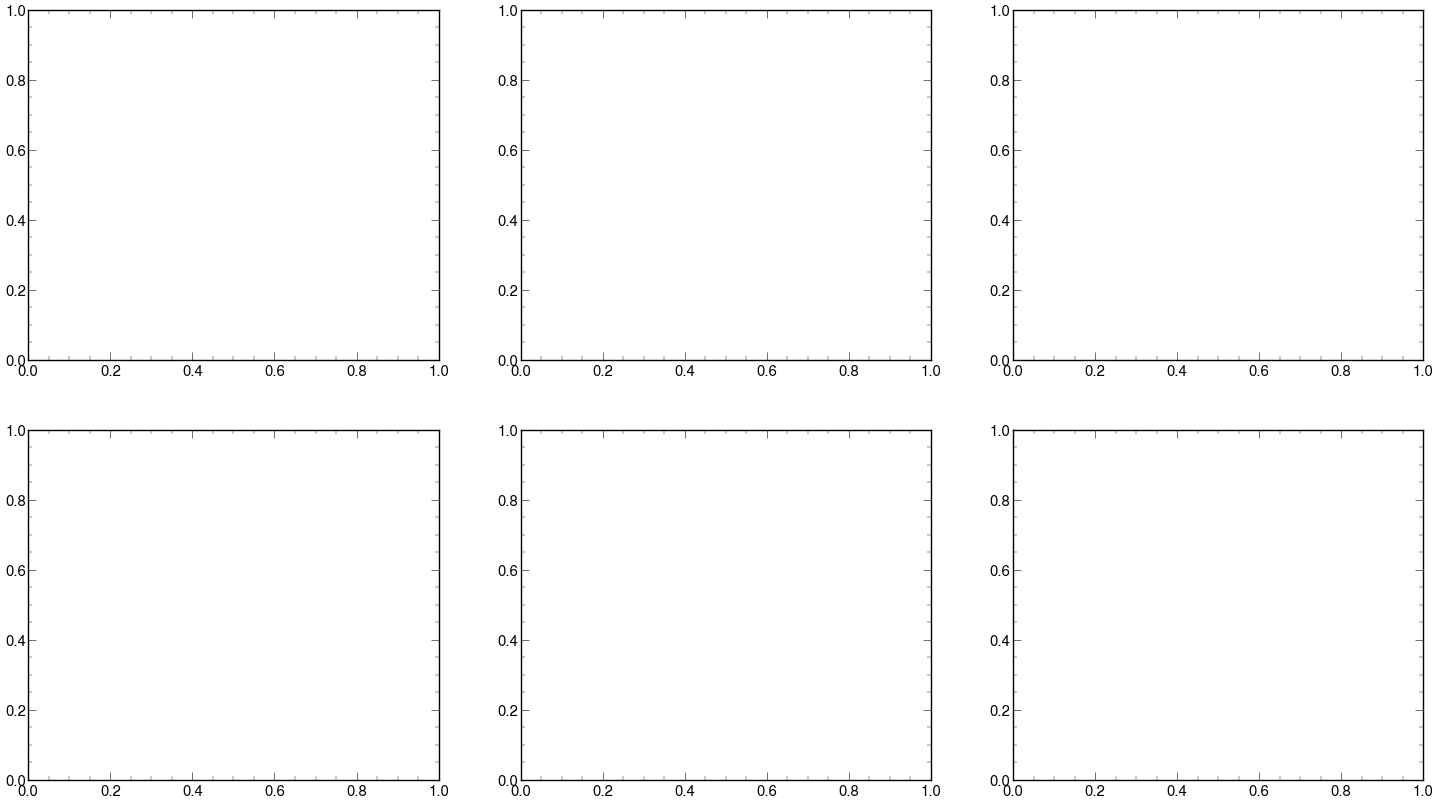

In [94]:
plt.style.use(hep.style.CMS)
fig, ax = plt.subplots(2, 3, figsize=(36, 20)) 

plotting(events_4mu, "4mu_1000GeV_0p25GeV_0p002mm", 0.002,0,0, "orangered")
plotting(events_4mu, "4mu_1000GeV_0p25GeV_0p02mm", 0.02,0,1, "darkorange")
plotting(events_4mu, "4mu_1000GeV_0p25GeV_0p2mm", 0.2,0,2, "limegreen")
plotting(events_4mu, "4mu_1000GeV_0p25GeV_1p0mm", 1,1,0, "royalblue")
plotting(events_4mu, "4mu_1000GeV_0p25GeV_2p0mm", 2,1,1, "darkmagenta")

DP mass : [[1.21, 1.2], [1.2, 1.2], [1.18, 1.2], ... [1.2, 1.19], [1.2, 1.19], [1.23, 1.19]]
DP mass : [[1.21, 1.2], [1.2, 1.19], [1.2, 1.2], ... [1.2, 1.23], [1.2, 1.2], [1.2, 1.3]]
DP mass : [[1.2, 1.2], [1.2, 1.2], [1.18, 1.2], ... [1.2, 1.17], [1.29, 1.26], [1.2, 1.2]]
DP mass : [[1.2, 1.2], [1.21, 1.19], [1.2, 1.2], ... [1.23, 1.22], [1.2, 1.2], [1.18, 1.2]]
DP mass : [[1.2, 1.18], [1.21, 1.19], [1.2, 1.2], ... [1.16, 1.21], [1.2, 1.2], [1.2, 1.22]]


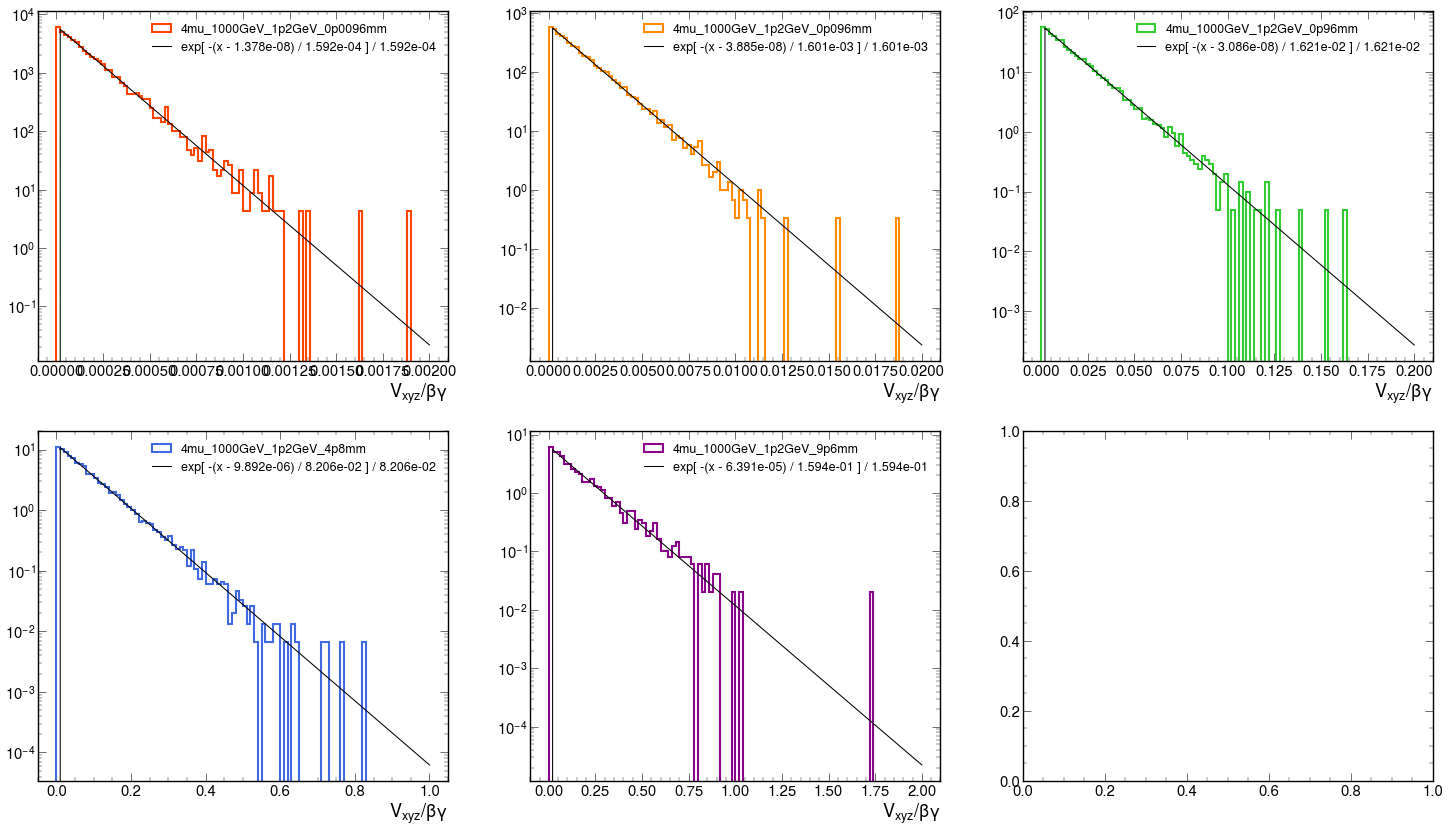

In [87]:
plt.style.use(hep.style.CMS)
fig, ax = plt.subplots(2, 3, figsize=(36, 20)) 

plotting(events_4mu, "4mu_1000GeV_1p2GeV_0p0096mm", 0.002,0,0, "orangered")
plotting(events_4mu, "4mu_1000GeV_1p2GeV_0p096mm", 0.02,0,1, "darkorange")
plotting(events_4mu, "4mu_1000GeV_1p2GeV_0p96mm", 0.2,0,2, "limegreen")
plotting(events_4mu, "4mu_1000GeV_1p2GeV_4p8mm", 1,1,0, "royalblue")
plotting(events_4mu, "4mu_1000GeV_1p2GeV_9p6mm", 2,1,1, "darkmagenta")

DP mass : [[5, 5.02], [4.98, 4.97], [4.98, 5], [5.02, 5, ... 5.02], [5, 5], [5.06, 5], [5, 5]]
DP mass : [[4.98, 4.95], [5, 4.97], [5.03, 5], [5, ... 4.98], [5, 4.98], [5, 5], [4.98, 5]]
DP mass : [[5.02, 5], [5, 5], [5.02, 5], [5, 5.03], ... [5, 5], [5.05, 5], [5, 5], [5, 5]]
DP mass : [[4.98, 5], [4.98, 5], [5, 4.97], [5, 5], ... 5.02, 5], [5.02, 5], [4.98, 5], [5, 5]]
DP mass : [[5, 5], [5, 5], [5, 5], [5, 5.02], ... [5, 5], [5, 5], [4.98, 5], [5, 5.02]]


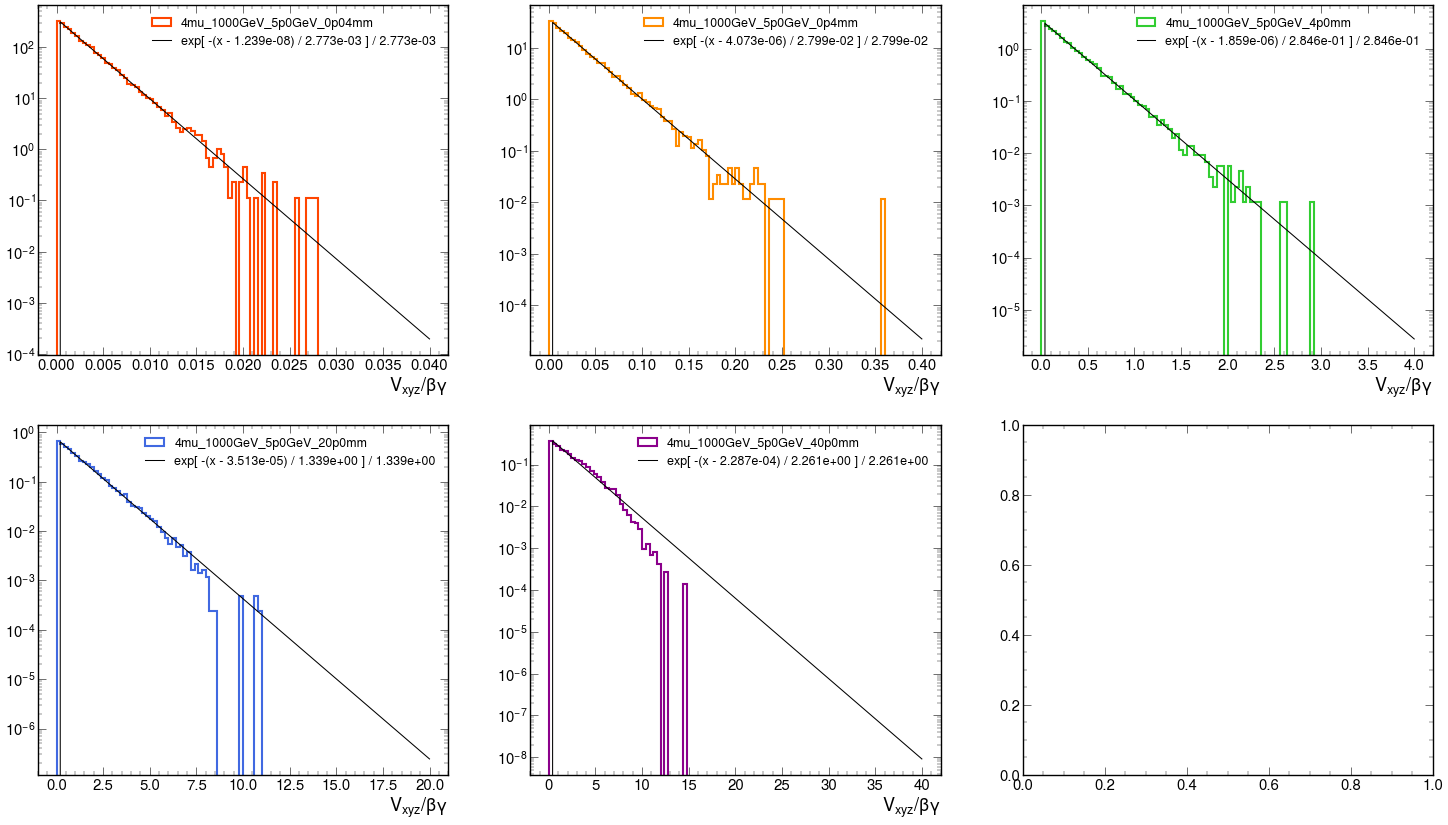

In [88]:
plt.style.use(hep.style.CMS)
fig, ax = plt.subplots(2, 3, figsize=(36, 20)) 

plotting(events_4mu, "4mu_1000GeV_5p0GeV_0p04mm", 0.04,0,0, "orangered")
plotting(events_4mu, "4mu_1000GeV_5p0GeV_0p4mm", 0.4,0,1, "darkorange")
plotting(events_4mu, "4mu_1000GeV_5p0GeV_4p0mm", 4,0,2, "limegreen")
plotting(events_4mu, "4mu_1000GeV_5p0GeV_20p0mm", 20,1,0, "royalblue")
plotting(events_4mu, "4mu_1000GeV_5p0GeV_40p0mm", 40,1,1, "darkmagenta")